#  Проект: Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Мы должны построить модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Этапы проекта

Вот что мы сделаем:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

## Содержание

* [Подготовка данных](#preparation) 
* [Анализ данных](#analysis)
* [Обучение моделей](#training)
* [Тестирование](#testing)
* [Вывод](#conclusion)

## Предварительные настройки

Первый блок — это импорты пакетов/библиотек, которые нам пригодятся в этом проекте:

In [1]:
# загружаем библиотеки для работы с данными
import pandas as pd
import numpy as np

# загружаем библиотеки для работы с графиками 
import matplotlib.pyplot as plt
from matplotlib import rcParams

# загружаем модули для работы с временными рядами
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

# загружаем пакеты для расчёта статистических параметров
from scipy.stats import kurtosis
from scipy.signal import find_peaks

# загружаем пакеты для обучения 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV

# загружаем модели
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# загружаем метрики
from sklearn.metrics import mean_squared_error

# загружаем вспомогательные инструменты
import warnings

Отдельным блоком объявляем различные константы:

In [2]:
# создаём константу локального пути к файлу
LOCAL_PATH = 'taxi.csv'
# создаём константу цветовой схемы для графиков
PALETTE = 'tab10'
# создаём константу случайного состояния
RANDOM_STATE = 42

Далее — вносим необходимые настройки нашего окружения:

In [3]:
# устанавливаем необходимые настройки для графиков 
sns.set_style('whitegrid')
sns.set_palette(PALETTE)

# настраиваем оси
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
# # настраиваем отсутпы
rcParams['axes.labelpad'] = 20
# настраиваем изображение
rcParams['figure.figsize'] = [12, 6]
rcParams['figure.autolayout'] = True
rcParams['figure.dpi'] = 300
# настраиваем размеры подписей
rcParams['font.size'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10

# настраиваем вывод предупреждений
warnings.filterwarnings("ignore")

Ниже объявлен самописный функционал, которые мы будем использовать по ходу проекта:

In [4]:
# объявляем функцию отрисовки временного ряда со скользящими
def time_series_plot(data, name='time series', rolling_window=3):
    '''
    Функция рисует линейный график временного ряда 
    со скользящими средним и стандартным отклонением.
    
    Параметры:
    ---------
    data : Series
        Временной ряд в виде серии.
    name : str (по умолчанию 'time series')
        Имя временного ряда.
    rolling_window : int (по умолчанию 3)
        Скользящее окно, которое будет применено
        к среднему и стандартному отклонению.
        
    Возвращает:
    -----------
    Функция возвращает фигуру графика, на которой размещаются 
    линейный график временного ряда, скользящие среднее и
    стандартное отклонение с заданным окном.
    '''
    # получаем скользящее среднее    
    mean = data.rolling(rolling_window).mean()
    # получаем скользящее стандартное отклонение     
    std = data.rolling(rolling_window).std()
    
    # строим общую фигуру графиков
    plt.figure(figsize=(12, 5))
    
    # строим график временного ряда
    plt.plot(data, label=name)
    # строим график скользящего средного
    plt.plot(mean, label='mean', color='tab:orange')
    # строим график скользящего отклонения
    plt.plot(std, label='std', color='tab:red')
    # выводим легенду
    plt.legend();

In [5]:
# объявляем функцию отрисовки автокорреляции
def time_series_acf(time_series, start=0, end=48):
    '''
    Функция строит парный график временного ряда
    в заданном диапазоне и коррелограмму с соответсвующим
    количеством лагов. Лаг задаётся как разность заданных
    границ диапазона.
    
    Параметры:
    ----------  
    time_series : Series
        Временной ряд в виде серии.
    start : int or str (по умолчанию 0)
        Начало диапазона временного ряда.
        Можно задать как индекс серии,
        так и строковое значение даты и время
    end : int or str (по умолчанию 48)
        Конец диапазона временного ряда.
        Можно задать как индекс серии,
        так и строковое значение даты и время
        
    Возвращает:
    -----------
    Функция возвращает два графика друг под другом:
    линейный график и коррелограмму временного ряда.
    '''
    # определяем количество лагов
    lags = time_series[start:end].shape[0]
    
    # строим общую фигуру для графиков
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    # строим график временного ряда с заданным лагом
    time_series[start:end].plot(legend=None, ax=ax[0])
    ax[0].set(title=f'График временного ряда с периодом {end}', xlabel='', ylabel='')
    
    # строим коррелограмму
    plot_acf(time_series, lags=lags, ax=ax[1])
    ax[1].set(title='Автокорреляция', xlabel='', ylabel='')

In [6]:
# объявляем функцию проверки стационарности ряда
def stationarity_test(time_series, critical_value=.05, display_details=False):
    '''
    Функция проверяет стационарность временного ряда
    по двум тестам: Дики-Фуллера и Квятковского-Филлипса-Шмидта-Шина.
    Принятие решения происходит в результате сравнения расчитанной 
    p-value и заданной стаистической значимости.
    
    Параметры:
    ----------
    time_series : Series
        Временной ряд в виде серии.
    critical_value : float (по умолчанию .05)
        Порог статистической значимости. Задаётся в виде доли.
    display_details : bool (по умолчанию False)
        Флаг для отображения деталей тестов. По умолчанию
        будет отображен результат решения каждого теста.
        Если True, то будут выводится все детали рассчитанных
        результатов.
        
    Возвращает:
    -----------
    Функция возвращает булево значение: True — ряд является
    стационарным, False — ряд является нестационарным.
    Если display_details=True, то будут возвращены дополнительные 
    сведения:
    
    Для теста Дики-Фуллера:
    Test Statistic : статистика теста
    p-value : вероятностное значение
    Number of Lags Used : количество используемых лагов
    Number of Observations Used : количество используемых наблюдений
    Critical Value (1%) : значение статистической значимости при 1%
    Critical Value (5%) : значение статистической значимости при 5%
    Critical Value (10%) : значение статистической значимости при 10%
    
    Для теста Квятковского-Филлипса-Шмидта-Шина:
    Test Statistic : статистика теста
    p-value : вероятностное значение
    Lags Used : количество используемых лагов
    Critical Value (10%) : значение статистической значимости при 10%
    Critical Value (5%) : значение статистической значимости при 5%
    Critical Value (2.5%) : значение статистической значимости при 2.5%
    Critical Value (1%) : значение статистической значимости при 1%
    
    Заметки:
    --------
    Так как функция возвращает результаты двух тестов, то могут возникнуть
    следующие ситуации:
    1. Оба теста заключают, что ряд не является стационарным. Ряд не стационарный.
    2. Оба теста заключают, что ряд является стационарным. Ряд стационарный.
    3. KPSS указывает на стационарность, а ADF указывает на не стационарность. 
    Ряд является стационарным по тренду. Тренд необходимо удалить, 
    чтобы сделать ряд строго стационарным. Ряд без тренда проверяется на стационарность.
    4. KPSS указывает на не стационарность, а ADF указывает на стационарность. 
    Ряд является разностно-стационарным. Необходимо произвести дифференцирование, 
    чтобы сделать ряд стационарным. Разностный ряд проверяется на стационарность.
    '''
    # проводим тест Дики-Фуллера      
    adf_test = adfuller(time_series)
    # получаем статус стационарности      
    adf_status = adf_test[1] < critical_value
    
    # проводим тест Квятковского-Филлипса-Шмидта-Шина    
    kpss_test = kpss(time_series, regression='c', nlags='auto')
    # получаем статус стационарности      
    kpss_status = kpss_test[1] > critical_value
    
    # условие для вывода деталей тестов
    if display_details:
        
        # оформляем результаты теста Дики-Фуллера     
        adf_results = pd.Series(
            # задаём значения         
            data=adf_test[0:4],
            # назначаем индексы         
            index=['Test Statistic', 'p-value', 
                   'Number of Lags Used',
                   'Number of Observations Used'])
        # циклом проходим по словарю статистической значимости      
        for key, value in adf_test[4].items():
            # добавляем значения в серию         
            adf_results['Critical Value (%s)' % key] = value
            
        # выводим детали теста Дики-Фуллера        
        print(f'Results of Dickey-Fuller Test:\n\n{adf_results}\n')
            
        # оформляем результаты теста Квятковского-Филлипса-Шмидта-Шина
        kpss_results = pd.Series(
            # задаём значения         
            data=kpss_test[0:3],
            # назначаем индексы         
            index=['Test Statistic', 'p-value', 
                   'Lags Used'])
        # циклом проходим по словарю статистической значимости     
        for key, value in kpss_test[3].items():
            # добавляем значения в серию         
            kpss_results['Critical Value (%s)' % key] = value
        
        
        # выводим детали теста Квятковского-Филлипса-Шмидта-Шина      
        print(f'Results of KPSS Test:\n\n{kpss_results}\n')
    
    # выводим заключение тестов         
    print('ADF status:', adf_status)
    print('KPSS status:', kpss_status)

# Подготовка данных <a class='anchor' id='preparation'></a>

Сперва подготовим наши данные: загрузим файл в проект и ознакомимся с его содержимым.

In [7]:
# загружаем данные локально
ts = pd.read_csv(LOCAL_PATH)

In [8]:
# выводим первые строки данных
ts.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [9]:
# выводим общую информацию
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные загрузились без ошибок. Таблица содержит следующие столбцы:

* `datetime` — значение даты и времени;
* `num_orders` — количество заказов.

Перед нами временной ряд — количество заказов такси в определённый момент времени. Судя по первым строкам таблицы интервал отсчёта составляет 10 минут. Всего мы наблюдаем $26496$ временных отсечек, пропусков нет.

Преобразуем дату и время в удобный тип данных (`datetime64`). Для удобства установим индекс таблицы равным `datetime`. После чего проверим, уникальны ли даты и в хронологическом ли порядке расположены.

In [10]:
# изменяем тип данных
ts['datetime'] = pd.to_datetime(ts['datetime'])
# устанавливаем новый индекс
ts.set_index('datetime', inplace=True)

In [11]:
# проверяем уникальность дат
print('Уникальность дат:', ts.index.is_unique)
# проверяем хронологический порядок
print('Монотонность ряда:', ts.index.is_monotonic)

Уникальность дат: True
Монотонность ряда: True


Так как нам нужно спрогнозировать количество заказов такси на следующий час, то десятиминутная детализация на не нужна. Изменим интервал временного ряда на 1 час, а в качестве агрегированного значения выберем сумму заказов за этот час. 

In [12]:
# изменяем интервал временного ряда
ts = ts.resample('1H').sum()
# выводим временной ряд
ts.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь дата и время имеет соответствующий тип данных — `datetime64` — и находится в индексе таблицы. Они уникальны, а сам индекс имеет хронологический порядок. Интервал отсчёта временного ряда был изменён согласно условию задачи. Данные поготовлены должным образом и теперь мы можем переходить к анализу.

# Анализ данных<a class='anchor' id='analysis'></a>

Основной целью анализа данных является выявление закономерностей, которые позволяют лучше понимать эти данные и принимать более правильные стратегические решения, основываясь на результатах анализа. 

Анализ временных рядов, в свою очередь, основывается на исходном  предположении, что случившееся в прошлом служит достаточно надежным указанием на то, что произойдет в будущем. В таком случае, основной целью анализа временных рядов является определение природы ряда и его структуры, с последующей идентификацией модели, которая способна более точно описать изменение значений во времени. С помощью такой модели мы можем легко интерпретировать рассматриваемые данные и экстраполировать ряд (предсказать его будущие значения).

Как показывает [практика](https://habr.com/ru/companies/ods/articles/327242/#lineynye-i-ne-ochen-modeli-na-vremennyh-ryadah), применение моделей машинного обучения как, например, *регрессии*, даёт результаты не хуже классических моделей прогнозирования временных рядов, таких как *экспоненциалное сглаживание*, или семейство *ARMA*. Для тех и других моделей важно понимать особенности рассматриваемого временного ряда. Отличием является только то, что для моделей машинного обучения необходимо построить новые независимые признаки на основе этих особенностей. А для классических моделей особенности (природа ряда и его структура) явялются критерием выбора самой модели.

Независимо от того, какой из методов прогнозирования мы выберем, нам необходимо выяснить:

* есть ли общая тенденция изменения значений (тренд);
* имеются ли периодические циклы (сезонность);
* присутствуют ли ошибки (случайный шум);
    
Начнём с общего описания: взглянем на график временного ряда, узнаем его диапазон и распределение значений.

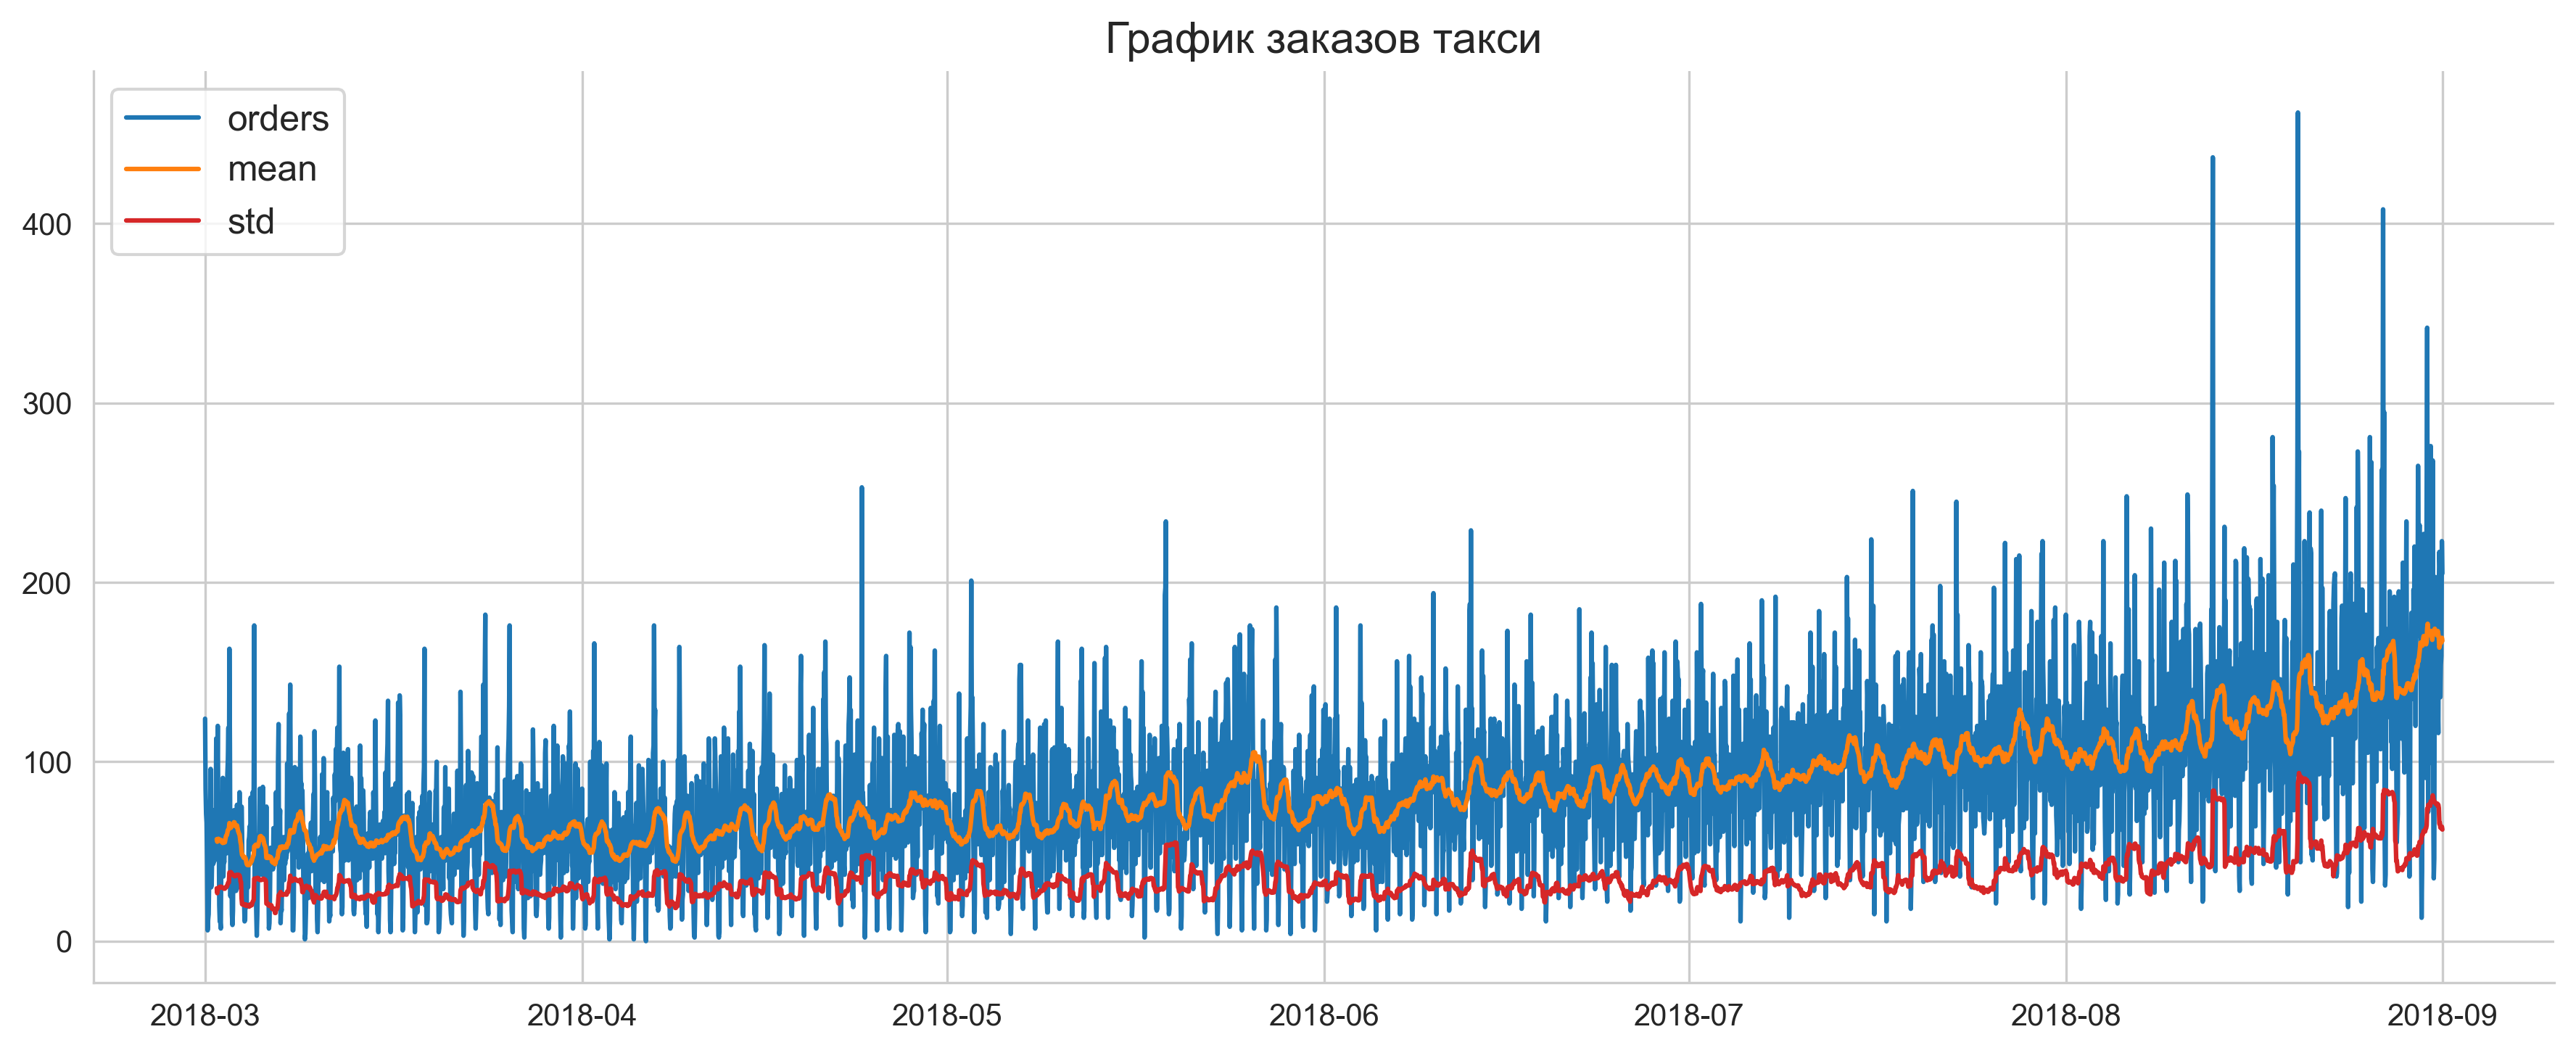

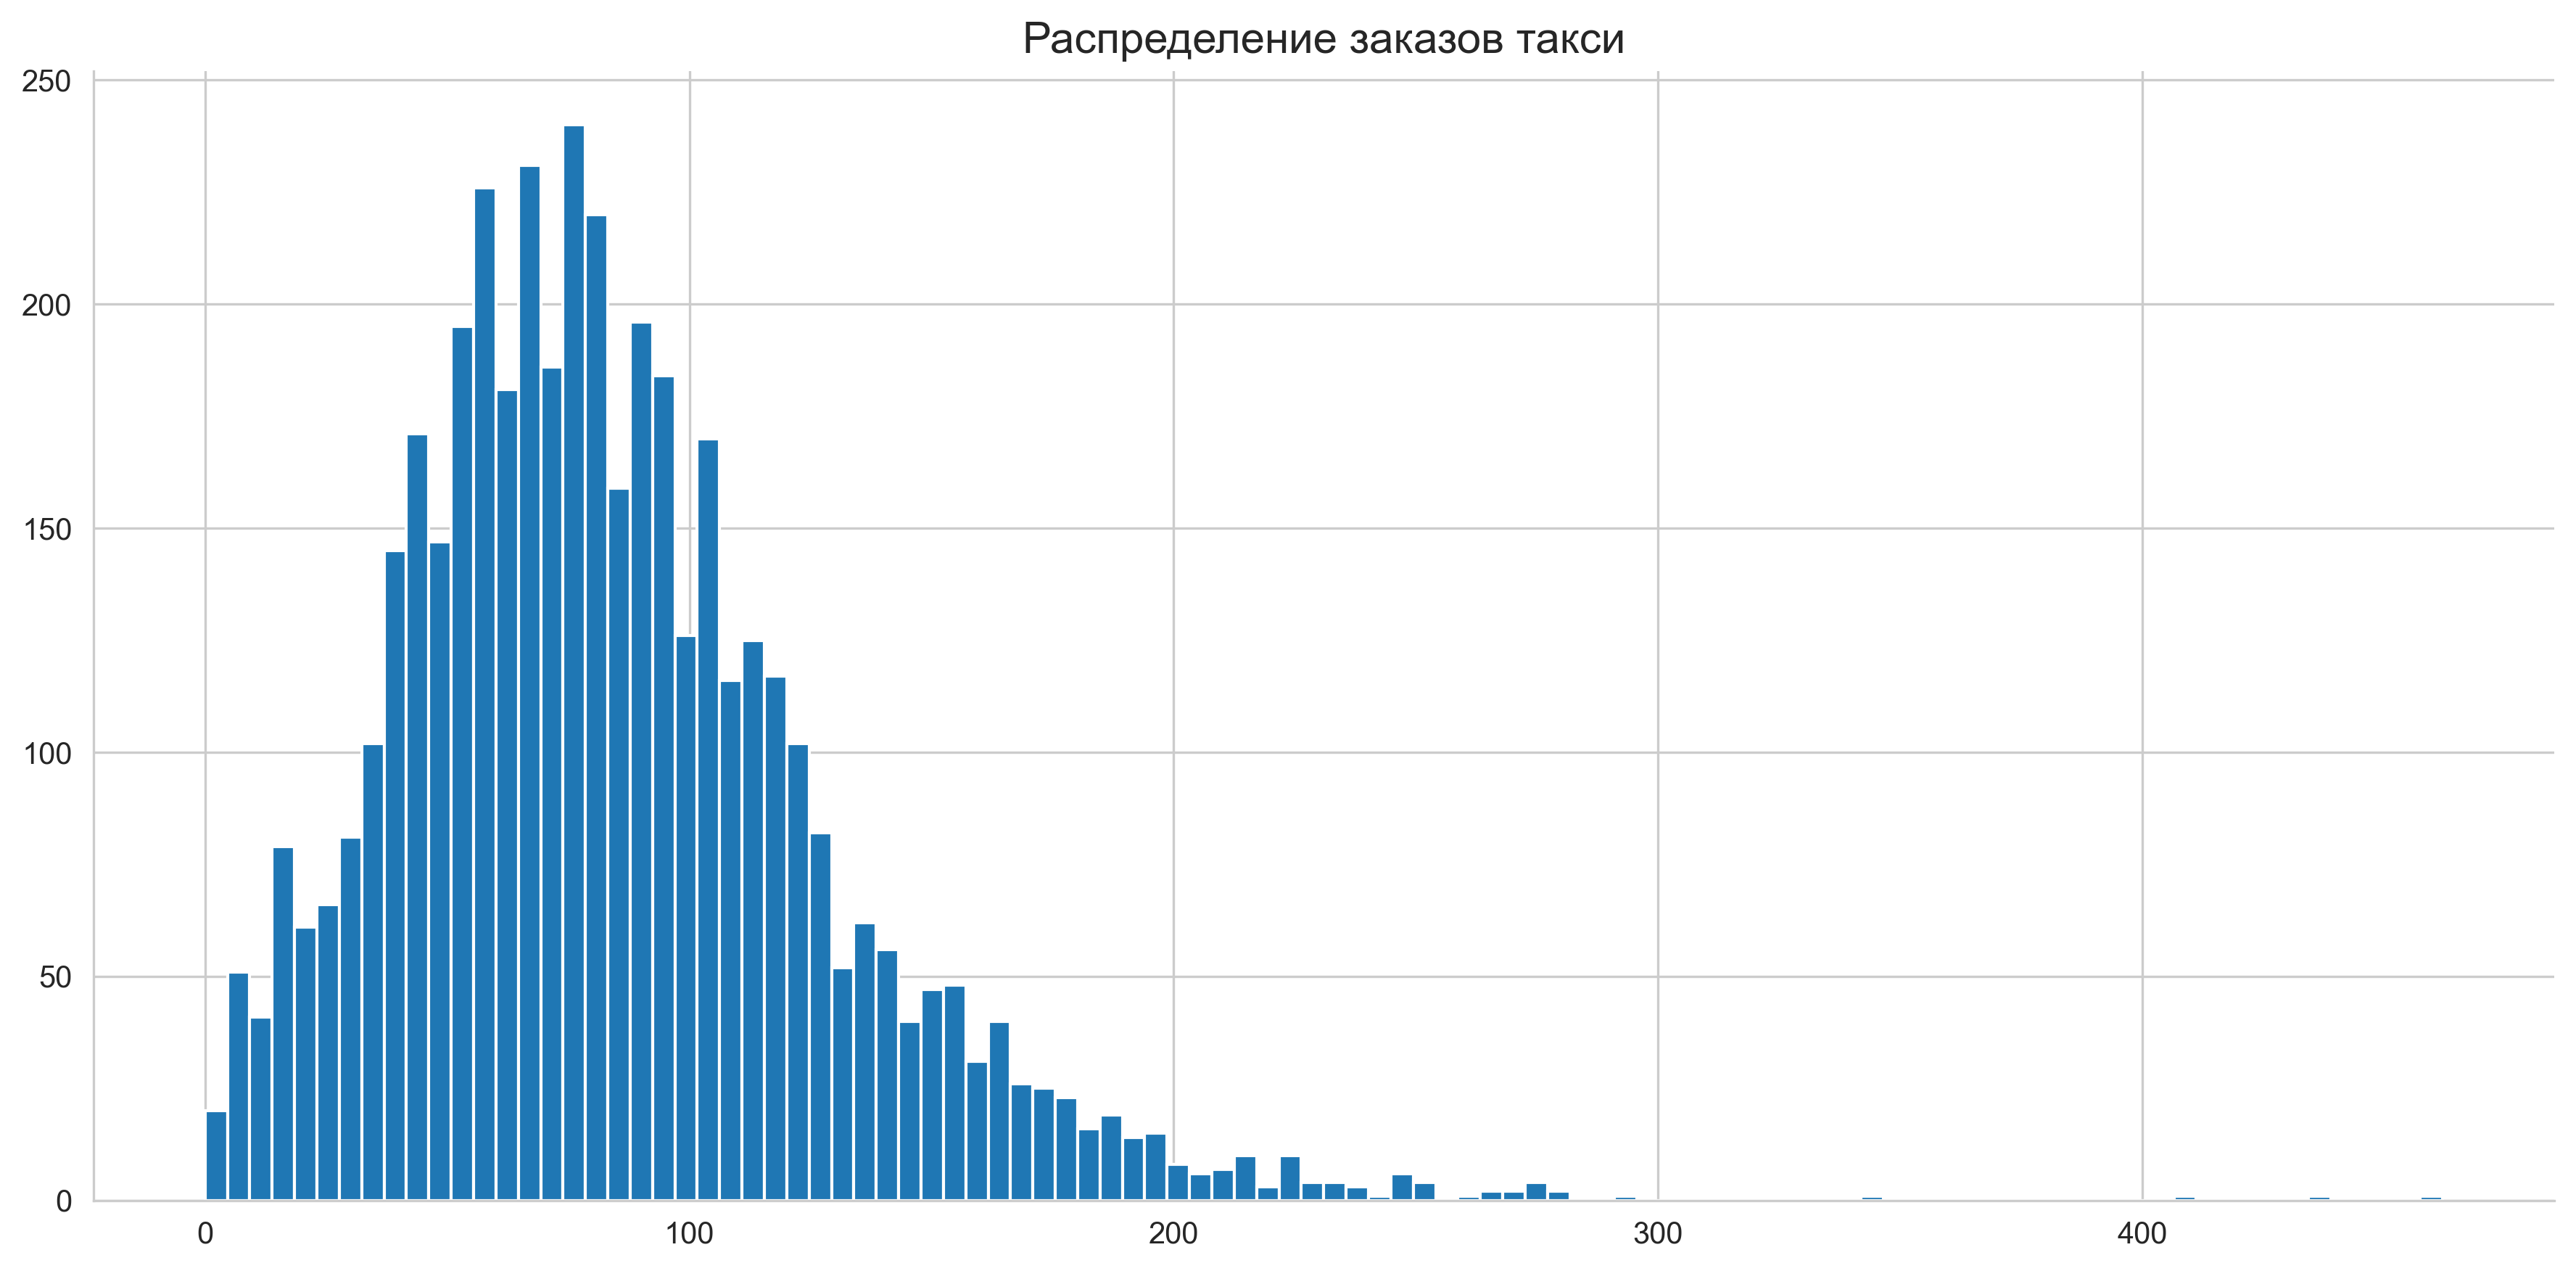

In [13]:
# строим график временного ряда
time_series_plot(ts, name='orders', rolling_window=24)
plt.title('График заказов такси')

# строим гистограмму распределения значений
ts.hist(bins=100)
plt.title('Распределение заказов такси');

In [14]:
# получаем диапазон ряда
print('Начало временного ряда:', ts.index.min())
print('Конец временного ряда:', ts.index.max())
print('Диапазон:', ts.index.max() - ts.index.min())

# выводим суммарные статистики ряда
print('Среднее значение:', int(ts.mean()))
print('Стандартное отклонение:', int(ts.std()))

Начало временного ряда: 2018-03-01 00:00:00
Конец временного ряда: 2018-08-31 23:00:00
Диапазон: 183 days 23:00:00
Среднее значение: 84
Стандартное отклонение: 45


На графике мы наблюдаем временной ряд заказов такси за период с 1 марта 2018 года по 31 августа 2018 года. Это значит, что под наблюдение попали два временных сезона — весна и лето. Годовую сезонность отследить мы не сможем из-за неполных данных. Также нам доступны такие уровни детализации как неделя, день, час. Напомним, текущий расчёт временного ряда — 1 час. Всё это пригодится нам для выявления тенденций и периодических закономерностей ряда.

Наблюдается некий тренд. Есть ощущение, что с марта по июнь он никак не менялся, а начиная с июня, наращивает обороты роста. Наличие шума или других компонент ряда (чаще всего и то, и другое) затрудняют визуальный анализ тенденций. Поэтому следует разложить наш ряд на компоненты.   

Есть пиковые значения на протяжении всего ряда — большое количество заказов, случившиеся за один час времени. Эти значения мы наблюдаем в правом хвосте распределения. Само распределение близкое к нормальному, немного смещено влево. Есть нулевые значения (почему нет, такое возможно). Суммарные статистики говорят нам о том, что в среднем за час такси заказывают $84$ раза. Значения варьируются в среднем на $45$ заказов.

Разложим временной ряд на компоненты, чтобы оценить его состав. В качестве периода выберем сутки — 24 часа. 

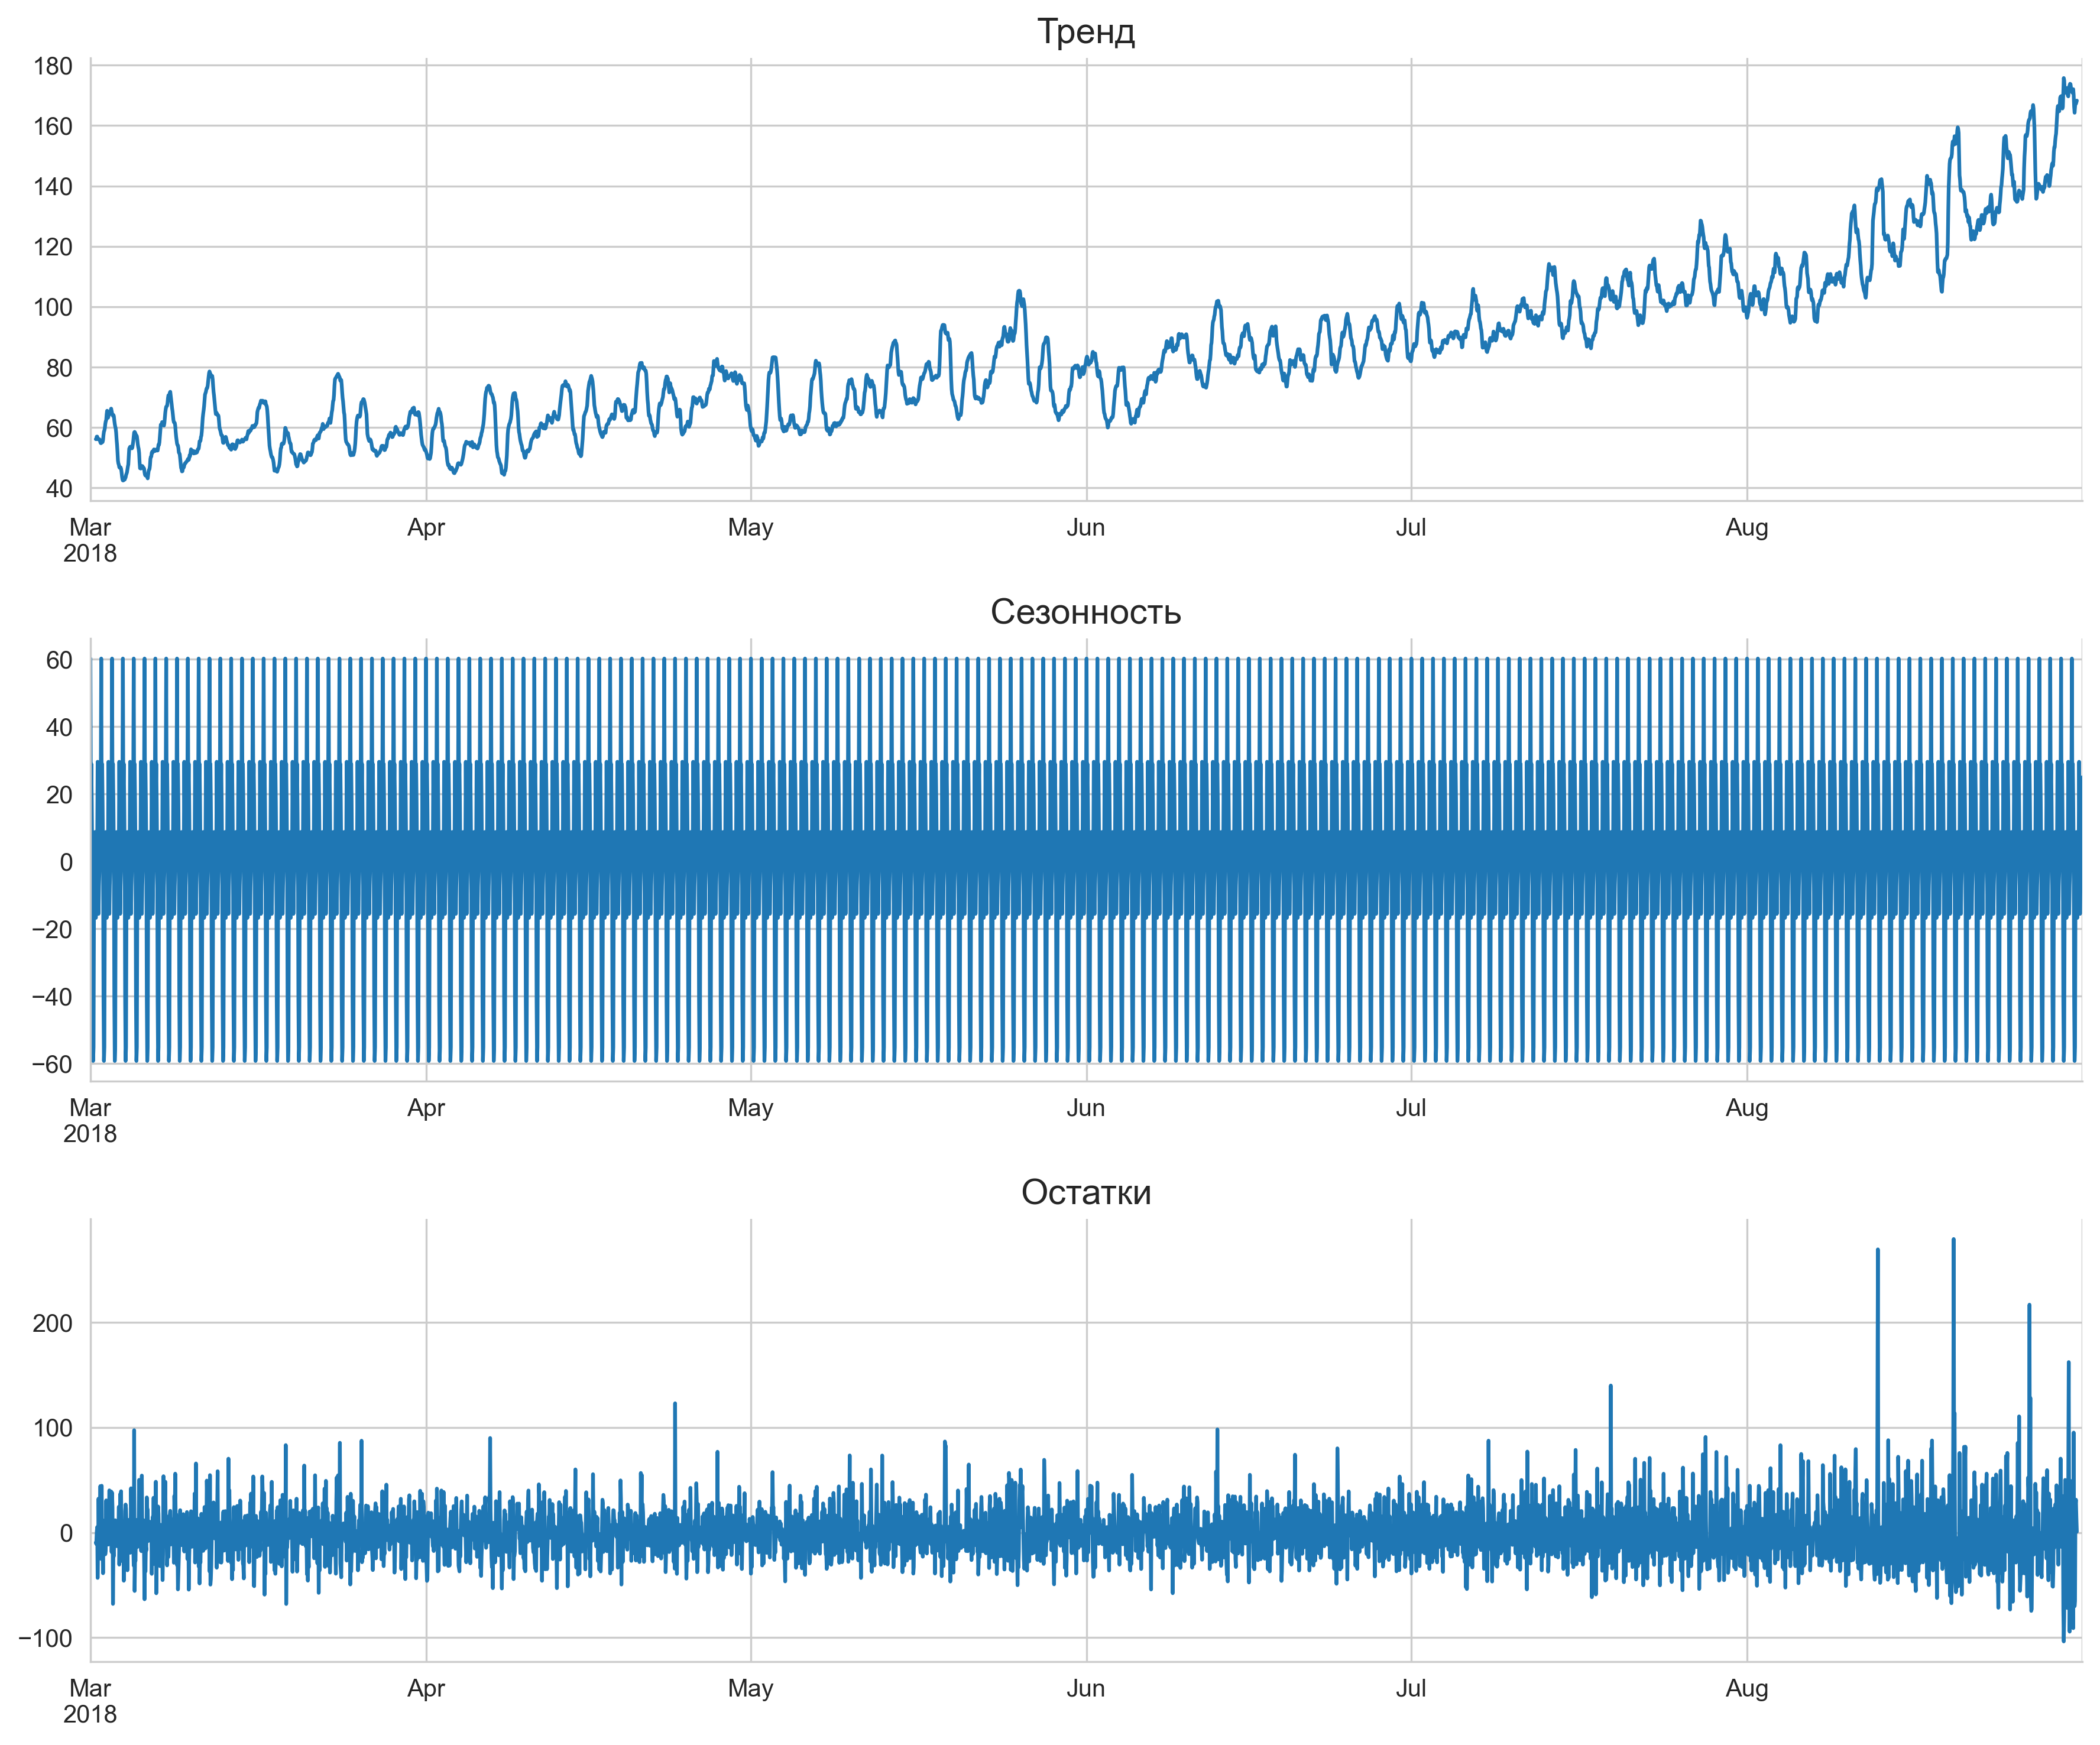

In [15]:
# декомпозируем временной ряд
decompose = seasonal_decompose(ts, period=24)

# строим общую фигуру для графиков
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# строим график тренда
decompose.trend.plot(ax=ax[0])
ax[0].set(title='Тренд', xlabel='', ylabel='')

# строим график сезонности            
decompose.seasonal.plot(ax=ax[1])
ax[1].set(title='Сезонность', xlabel='', ylabel='')

# строим график остатков            
decompose.resid.plot(ax=ax[2])
ax[2].set(title='Остатки', xlabel='', ylabel='');

Декомпозиция позволяет нам увидеть явный возрастающий тренд заказов. Дисперсия выглядит однородной. В сезонности наблюдается некая периодичность — колебания проявляются частыми циклами. Рассмотрим коррелограмму сезонности за 72 часа для выявления периода колебаний. Для этого воспользуемся самописной функцией. Она принимает на вход временной ряд и количество лагов, авозвращает два графика — линейный график и диаграмму автокорреляции.

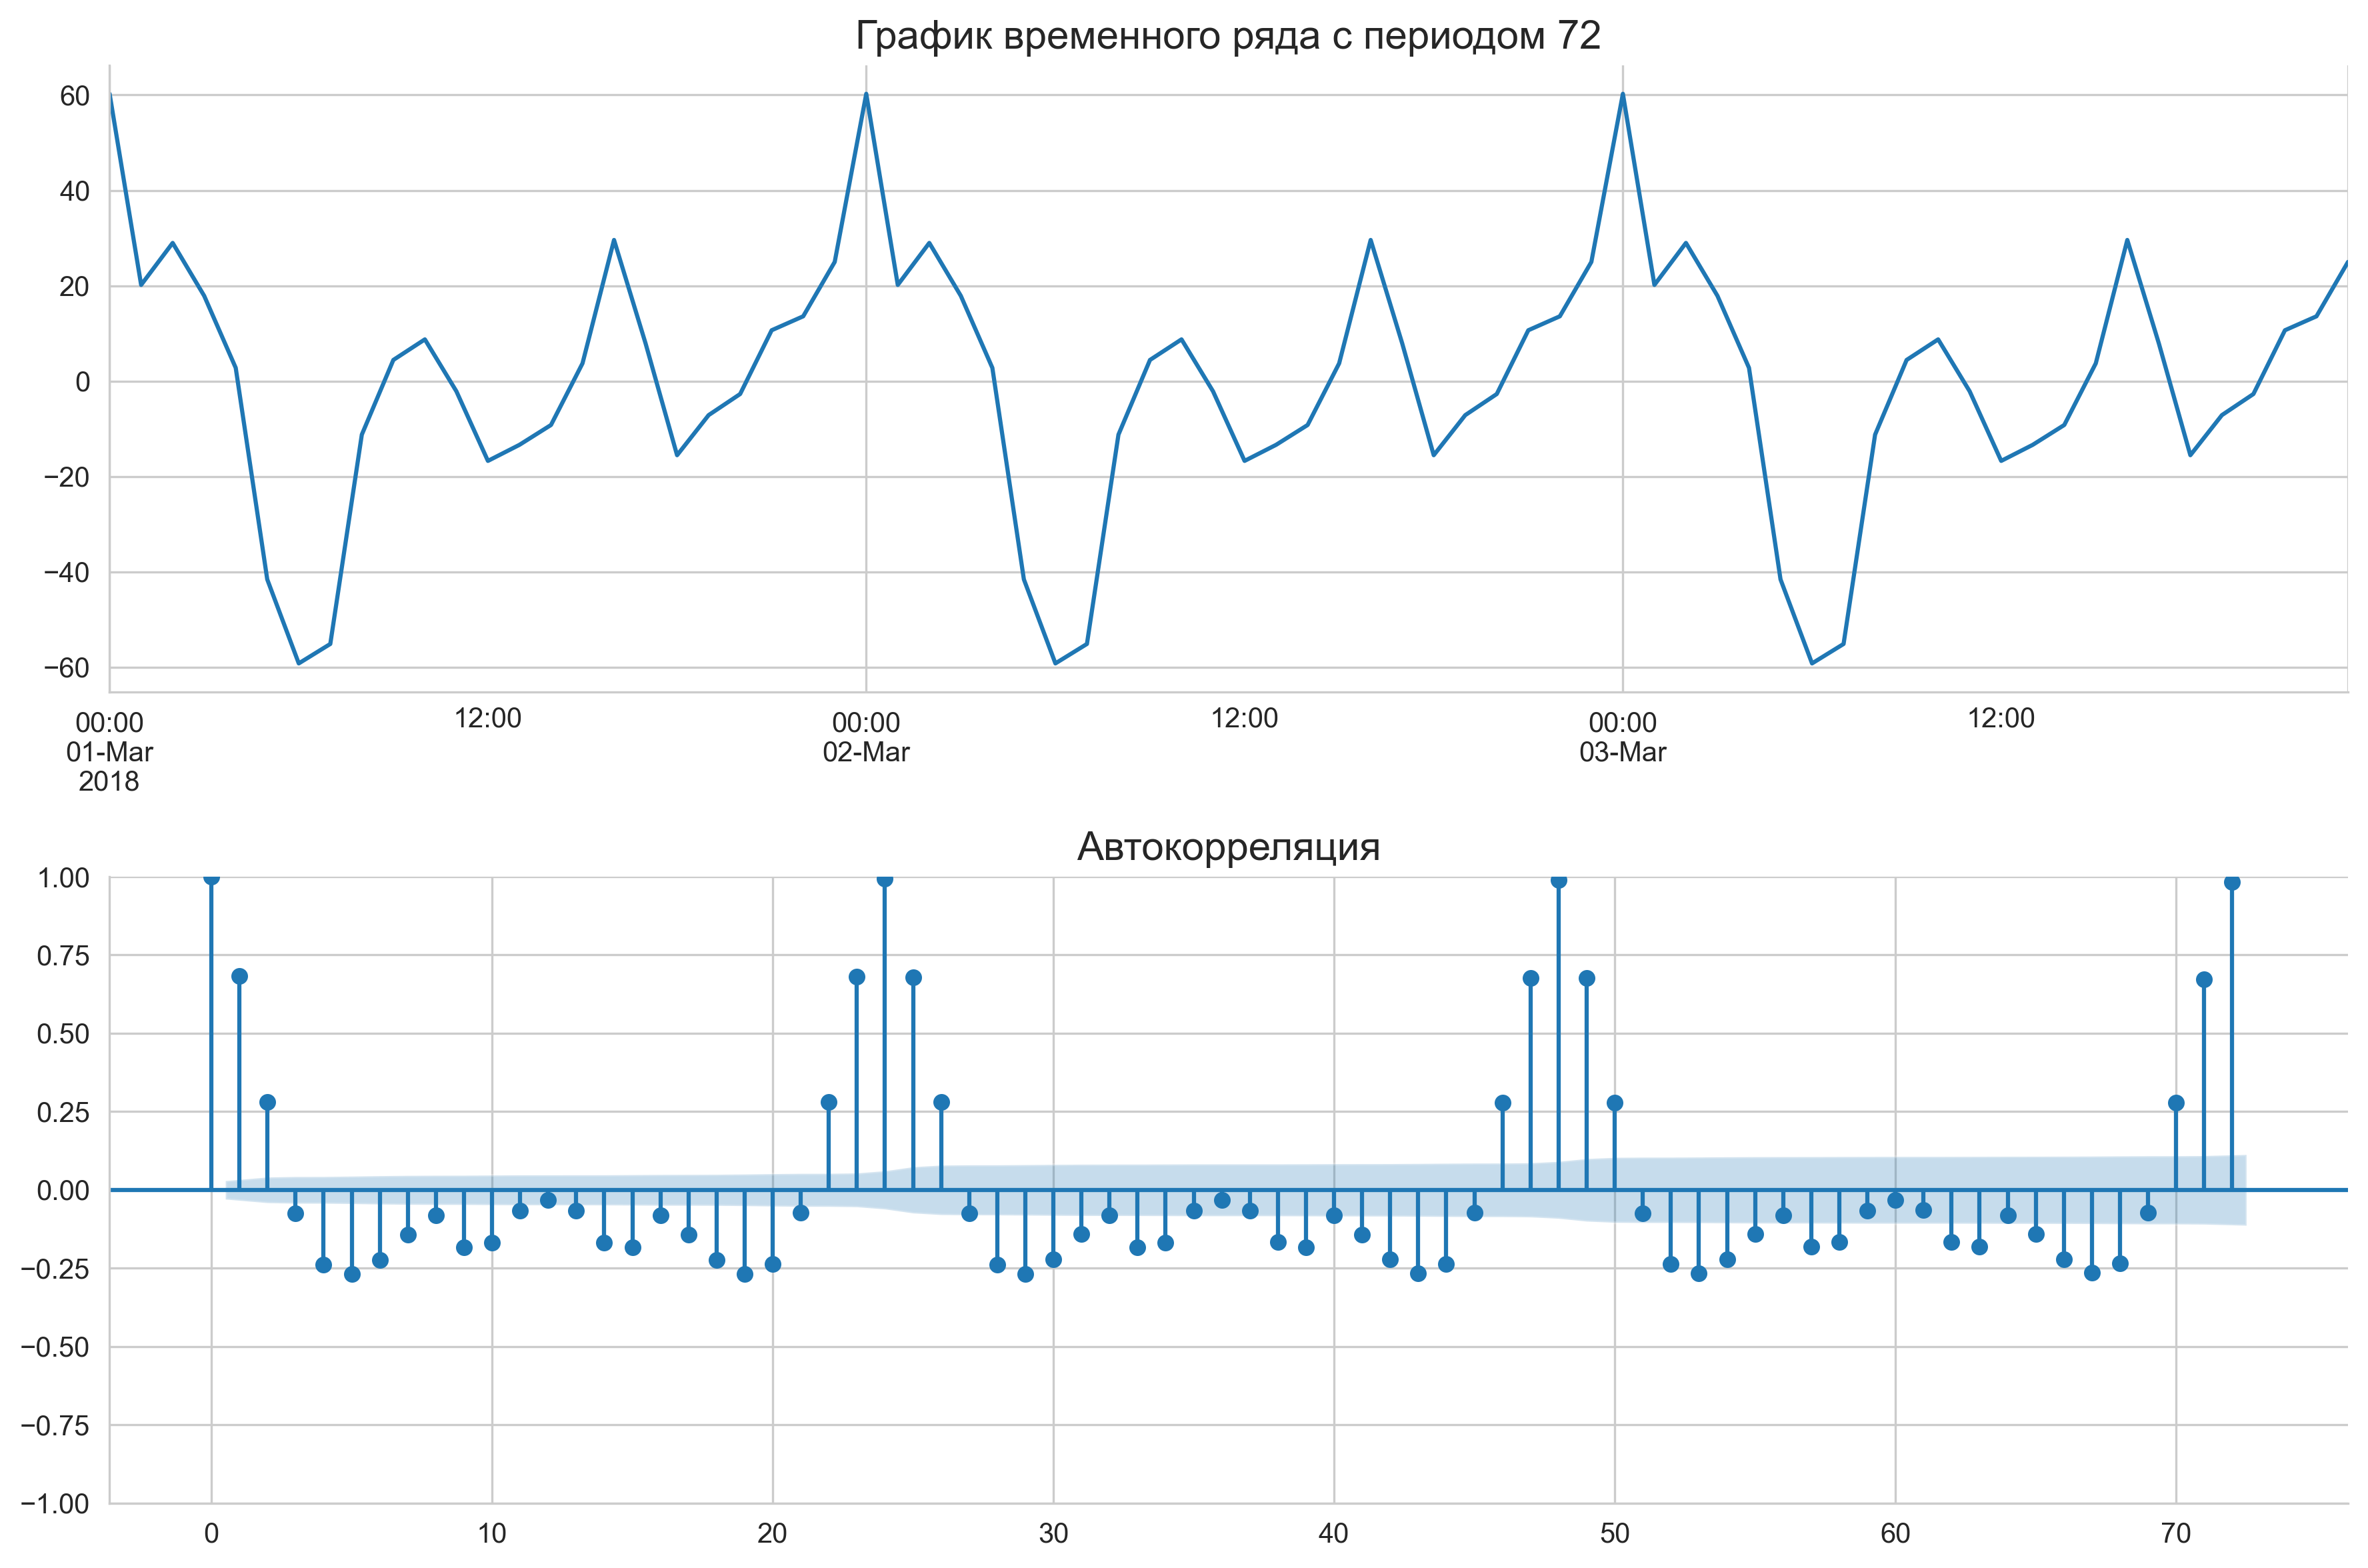

In [16]:
# строим коррелограмму сезонности
time_series_acf(decompose.seasonal, 0, 72)

Мы видим циклично повторяющийся рисунок. На коррелограмме каждый 24-ый лаг имеет сильную корреляцию с нулевым. Всё это говорит о том, что в компоненте сезонности присутствует суточная цикличность заказов. Рассмотрим детально один день и опишем динамику заказов.

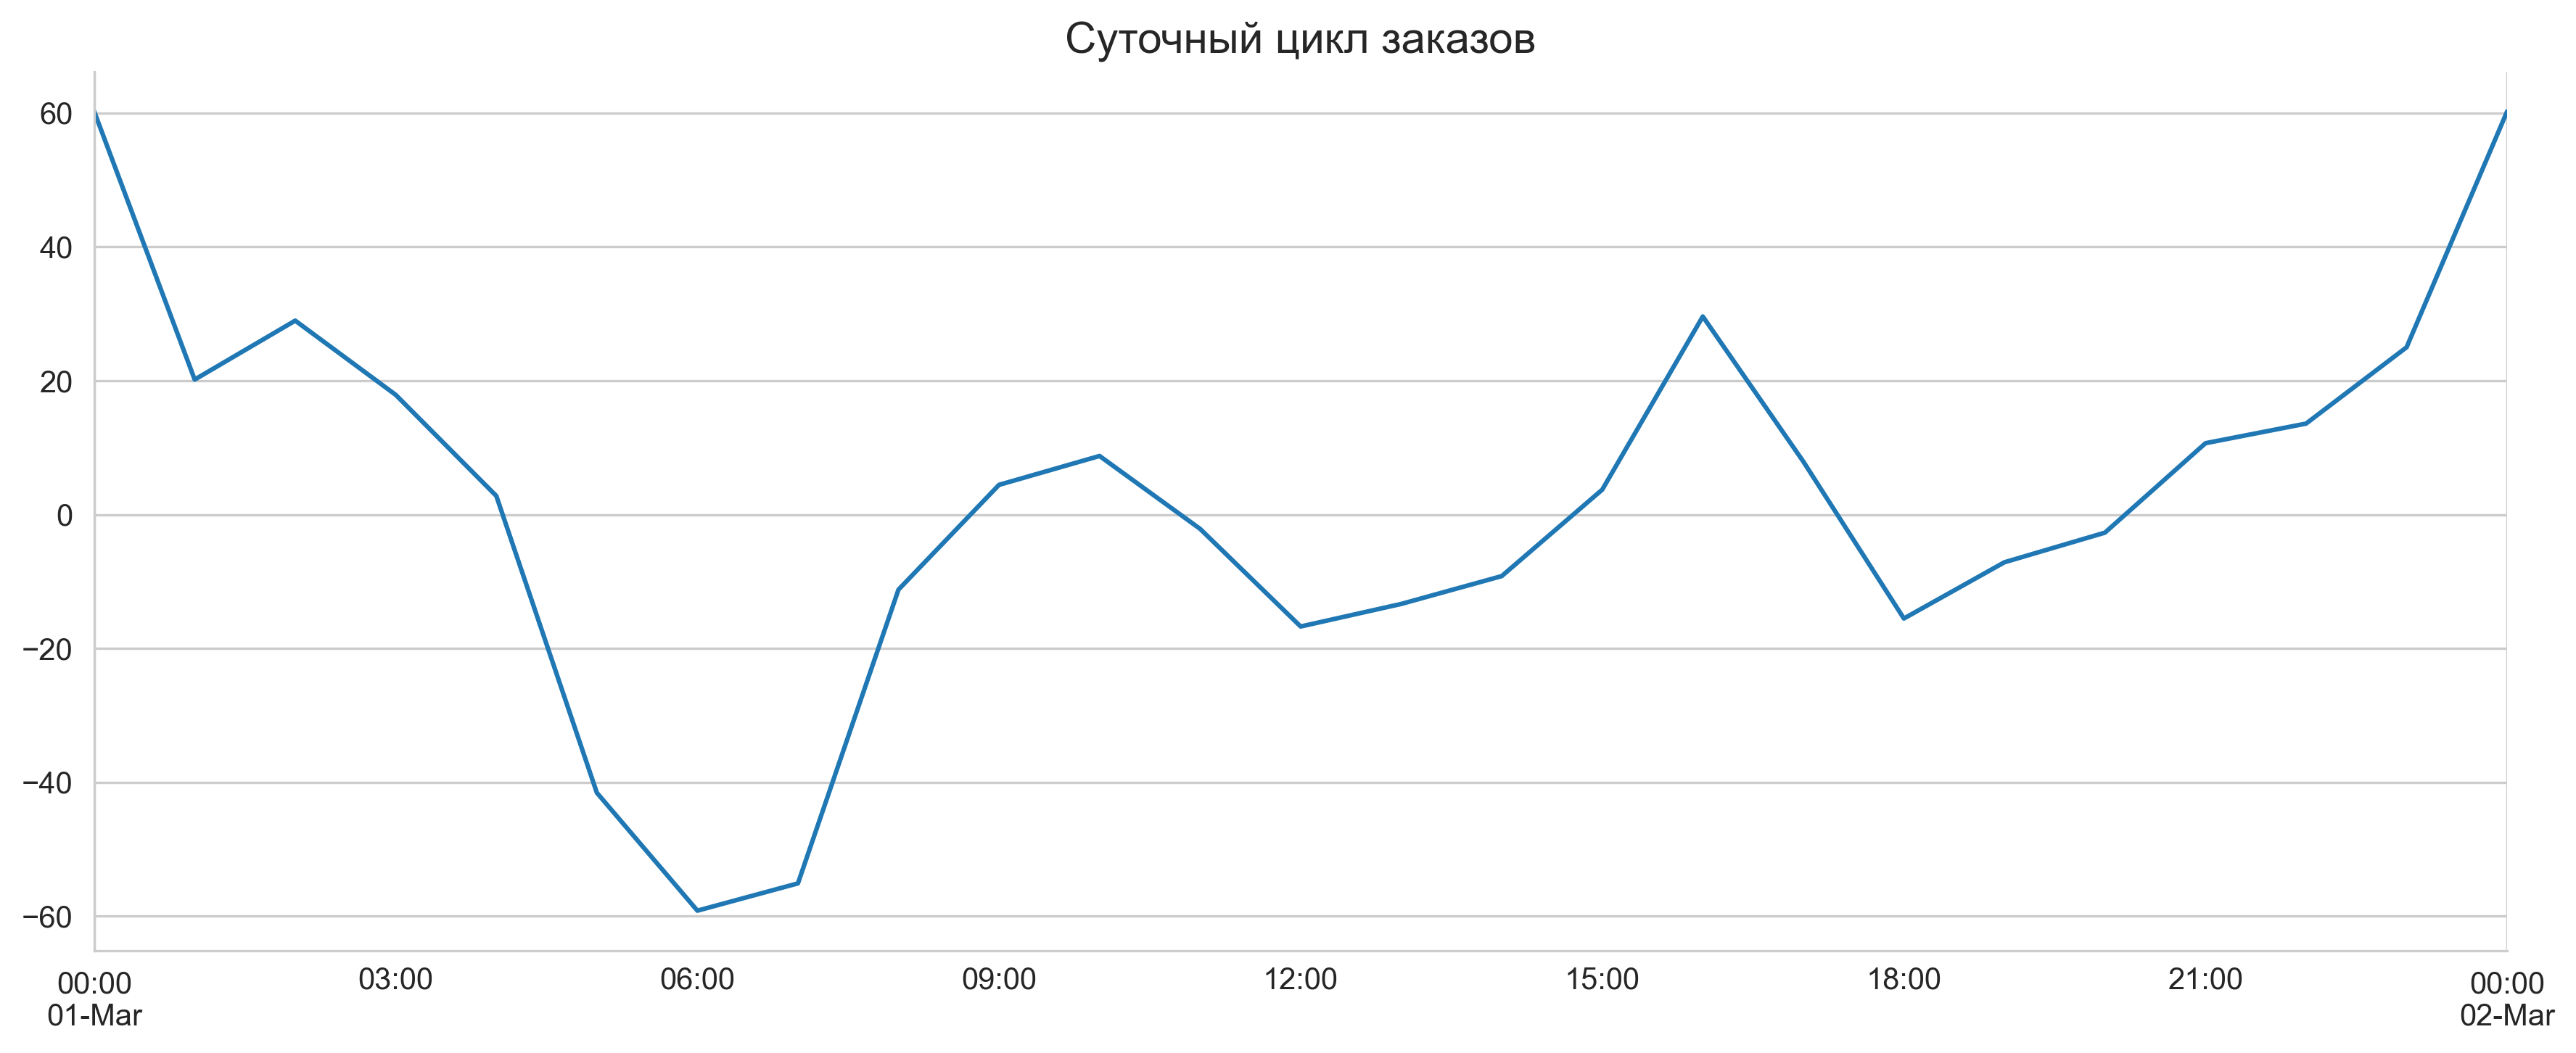

In [17]:
# строим график суточного цикла
decompose.seasonal[0:25].plot(figsize=(12, 5))
plt.title('Суточный цикл заказов')
plt.xlabel('')
plt.ylabel('');

Пиковое значение заказов приходятся на полночь. К шести утра заказы падают, достигая своего минимума. Начиная с 8 утра до 22 значение колеблется возле среднего. Локальные максимумы приходятся на 10 и 16 часов. К полуночи количество заказов опять достигает максимума. Всё подтверждается здравым смыслом:

* ночью люди чаще пользуются такси; 
* в ранние же часы передвижения минимальны, большинство спит; 
* в течение бизнес-дня достинается норма — утром на работу, вечером с работы; 
* к полуночи востребованность услугами возрастает.

Итак, на данный момент времени мы узнали, что временной ряд имеет положительный тренд, который растёт на рассматриваемом нами промежутке времени (март-август). В ряде имеются циклические суточные колебания: пик заказов приходится на полночь, минимум достигается к утру, в течение дня значения колеблются возле среднего. По всем визуальным наблюдениям мы имеем дело с нестационарным рядом. 

<a class='anchor' id='stationarity_test'></a>

Для формализации наших суждений проведём статистические тесты на стационарность ряда. Воспользуемся нашей самописной функцией `test_stationality`, которая будет проверять ряд по двум тестам — [Дики-Фуллера](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0) и [Квятковского-Филлипса-Шмидта-Шина](https://en.wikipedia.org/wiki/KPSS_test). По результатам теста функция внутри  сравнит полученные вероятностные значения со статисческой значимостью и вернёт нам вероятную гипотезу по каждому тесту. Так как функция предназначена для проверки стационарности, то по задуманной логике ответом будет либо `True` (стационарный ряд), либо `False` (не стационарный ряд). Также в функции нам доступны детали каждого теста. Для их вывода достаточно передать аргумент `display_details` со значением `True`.

В случае тестов Дики-Фуллера и Квятковского-Филлипса-Шмидта-Шина нулевые гипотезы $H_0$ отвергаются, если `p-value` меньше статистической значимости. Напомним гипотезы.

* Для Дики-Фуллера: $H_0$ — ряд не стационарен; $H_1$ — ряд стационарен;
* Для Квятковского-Филлипса-Шмидта-Шина: $H_0$ — ряд стационарен; $H_1$ — ряд не стационарен.

In [18]:
# тестируем ряд на стационарность
stationarity_test(ts, display_details=True)

Results of Dickey-Fuller Test:

Test Statistic                   -3.068924
p-value                           0.028940
Number of Lags Used              30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64

Results of KPSS Test:

Test Statistic           10.913353
p-value                   0.010000
Lags Used                32.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

ADF status: True
KPSS status: False


В обоих случаях `p-value` меньше статистической значимости, нулевые гипотезы отвергаются. По результатам тестов, *ADF* подтвердил, что ряд стационарный, а *KPSS* — нестационарный. Этот спорный случай предусмотрен и описан в [документации](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#Stationarity-and-detrending-(ADF/KPSS)): «Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.» По этой рекомендации нам необходимо произвести диффернецирование временного ряда, тем самым избавившись от тенденций. Дифференцирование приводит к стационарности, а как нам известно, стационарные ряды лучше прогнозируются. Это верно для *ARIMA-like* моделей. Но для моделей классического машинного обучения стационарность ряда не критична. Мы учтём данный факт.

# Обучение моделей <a class='anchor' id='training'></a>

Прежде чем перейти к обучению моделей нам необходимо определитиься с инструментарием и под него должным образом подготовить временной ряд. 

1. Для прогнозирования временного ряда мы выберем методы машинного обучения. Данные методы, например, использование простой регрессии для предсказания временных рядов, являются современным решением этой проблемы, которое хорошо себя [зарекомендовало](https://youtu.be/u433nrxdf5k?t=4700) на практике. В качестве «предсказателей» у нас будут:

    * линейная регрессия как самая простая регрессия;
    * ElasticNet как регрессия с регуляризацией;
    * случайный лес как ансамбль деревьев со своим набором правил принятия решений;
    * LightGBM и CatBoost как представители градиентных бустингов — прокачанных моделей машинного обучения.
    

2. Так как выбранный нами метод прогнозирования основывается на системе независимых переменных и цели, то для этого нам необходимо модифицировать временной ряд: сгенерировать новые признаки на основе нашего ряда. Приводить ряд к стационарности нет смысла, потому что мы будем использовать модели машинного обучения;
3. Чтобы у нас была возможность контролировать качество предсказаний нам следует разделить временной ряд на тренировочный и проверочный. В первом будет зафиксированно настоящее (текущее время), во втором — некое будущее, которое нам надо предсказать.
4. Для проверки качества моделей мы будем использовать кросс-валидацию. Так как у нас не обычные данные, а временной ряд, то и разбиение при перекрёстной проверке должно быть соответствующее.

Начнём с создания признаков. Выделим из временного ряда:

* **календарные признаки** — тренды и сезонность привязаны к конкретной дате, поэтому имеет смысл из даты выделить месяц, месячный день, день недели. Также полезно будет пометить выходные дни. Так как временной ряд имеет явные часовые циклы, то очень важно выделить часы;
* **отстающие значения** — предыдущие значения ряда подскажут, будет ли функция $x(t)$ расти или уменьшаться. Для этого выделим лаги как одтдельные признаки. Сдвиг значений сделаем от 1 часа до суток, так как (опять таки) мы наблюдаем часовую цикличность;
* **скользящие агрегации и параметры** — скользящие среднее и стандартное отклонение как признаки зададут общий тренд ряда. Количество пиков и [эксцесс Фишера](http://www.mathprofi.ru/asimmetriya_i_excess.html) как признаки формы распределения. Выберем 3 и 6 часовые окна на основании наблюдаемой часовой динамики ряда.

In [19]:
# объявляем функцию для создания признаков
def make_features(ts):
    '''
    Функция создаёт признаки на основе временного ряда.
    Из ряда выделяются календарные признаки (месяц, календарынй день,
    день недели, выходной день, час), отстающие значения (лаги),
    сользящие агрегации и параметры (среднее, стандартное отклонение,
    количество пиков, эксцесс Фишера).
    
    Параметры:
    ----------
    ts : Series
        Временной ряд в виде серии.
        
    Возвращает:
    -----------
    Функция возвращает копию датафрейма
    с добавленными признаками.
    '''
    # создаём копию ряда
    df = ts.copy(deep=True)

    # создаём календарные признаки
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    # помечаем выходные дни 
    df['is_weekend'] = df.index.weekday.isin([5, 6]).astype(int)
    # выделяем часы
    df['hour'] = df.index.hour

    # создаём отстающтие значения
    for lag in range(1, 24):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    # создаём скользящие агрегации    
    df['rolling_mean'] = df['num_orders'].shift().rolling(6).mean()
    df['rolling_std'] = df['num_orders'].shift().rolling(6).std()
    # создаём скользящие индикаторы
    df['kurtosis'] = df['num_orders'].shift().rolling(6).apply(lambda x: kurtosis(x))
    df['peaks'] = df['num_orders'].shift().rolling(3).apply(lambda x: len(find_peaks(x)[0]))
    
    # возвращаем результат     
    return df

In [20]:
# создаём признаки
df = make_features(ts)
# проверяем результат
df.head()

,num_orders,month,day,weekday,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling_mean,rolling_std,kurtosis,peaks
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,0,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,0,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,0,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2018-03-01 04:00:00,43,3,1,3,0,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Разделим новый датафрейм на обучающую и тестовую выборки. По условию задачи на тест мы выделим 10% данных. Это должны быть последние по времени наблюдения, поэтому при разделении нам не стоит перемешивать данные. При создании признаков у нас появились пропущенные значения из-за скользящих окон и лагов. После разделения они попадут в тренировочную выборку, там мы от них и избавимся. Также нам надо отделить независивые признаки от цели. В конце обязательно проверим результаты.

In [21]:
# разделяем данные на выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)

# удаляем пропущенные значения
train.dropna(inplace=True)

# разделяем признаки
X_train, X_test = train.drop('num_orders', axis=1), test.drop('num_orders', axis=1)
y_train, y_test = train['num_orders'], test['num_orders']

# проверяем результаты
print(f'''Размер X_train: {X_train.shape}
Размер y_train: {y_train.shape}

Размер X_test: {X_test.shape}
Размер y_test: {y_test.shape}

Пропуски X_train: {X_train.isna().sum().sum()}
Пропуски y_train: {y_train.isna().sum().sum()}

Начало X_train: {X_train.index.min()}
Конец X_train: {X_train.index.max()}

Начало X_test: {X_test.index.min()} 
Конец X_test: {X_test.index.max()}''')

Размер X_train: (3951, 32)
Размер y_train: (3951,)

Размер X_test: (442, 32)
Размер y_test: (442,)

Пропуски X_train: 0
Пропуски y_train: 0

Начало X_train: 2018-03-01 23:00:00
Конец X_train: 2018-08-13 13:00:00

Начало X_test: 2018-08-13 14:00:00 
Конец X_test: 2018-08-31 23:00:00


Пропусков нет, все признаки на месте, хронология дат после разделения корректна. Теперь подготовим модели для обучения и получения первых результатов проверки. Также подготовим сводную таблицу для сохранения результатов эксперимента.  

In [22]:
# инициируем модели
linear = LinearRegression()
elastic = ElasticNet(random_state=RANDOM_STATE)
forest = RandomForestRegressor(random_state=RANDOM_STATE)
lgbm = LGBMRegressor(random_state=RANDOM_STATE)
catboost = CatBoostRegressor(random_state=RANDOM_STATE, logging_level='Silent')

# инициируем параметры для линейной регрессии
linear_params = {}

# инициируем параметры для логистической регрессии
elastic_params = {'alpha': [.1, .5, .9], 
                  'l1_ratio': [0, .5, 1]}

# инициируем параметры для случайного леса
forest_params = {'n_estimators': np.arange(100, 600, 100), 
                 'max_depth': np.arange(2, 16, 2), 
                 'ccp_alpha': [0, .2, .5, 1]}

# инициируем параметры для LGBM
lgbm_params = {'learning_rate': [.01, .05, .1, .5], 
               'max_depth': [5, 10, 15, -1]}

# инициируем параметры для CatBoost
catboost_params = {'learning_rate': [.01, .05, .1, .5], 
                   'max_depth': np.arange(4, 10, 1)}

# инициируем разделитель
tscv = TimeSeriesSplit()

In [23]:
# создаём список кортежей моделей и их параметров
models_list = [[linear, linear_params], [elastic, elastic_params], 
               [forest, forest_params], [lgbm, lgbm_params], 
               [catboost, catboost_params]]

# создаём сводную таблицу для результатов
results = pd.DataFrame(index=range(len(models_list)),
                       columns=['model', 'cv_score', 'fit_time', 'pred_time', 'total_time'])

In [24]:
%%time
# инициируем лучшую оценку
best_score = 999
# инициируем лучщую модель
best_model = None

# пакетно обучаем, проверяем модели и тюним модели
for i, candidate in enumerate(models_list):
    # инициализируем случайный поиск
    grid = RandomizedSearchCV(
        candidate[0], 
        param_distributions=candidate[1],
        scoring='neg_root_mean_squared_error',
        n_jobs=5,
        cv=tscv,
        verbose=5,
        error_score=0,
        random_state=RANDOM_STATE
    )
    
    # обучаем сетку     
    grid.fit(X_train, y_train)
    
    # получаем имя текущей модели     
    name = type(candidate[0]).__name__
    # получаем лучшую оценку     
    score = grid.best_score_.round(2) * -1
    # получаем время обучения
    fit_time = grid.cv_results_['mean_fit_time'].round(2)
    # получаем время предсказания
    pred_time = grid.cv_results_['mean_score_time'].round(2)
    # считаем общее время кросс-валидвации
    total_time = sum(fit_time + pred_time).round(2)
    
    # вносим результаты в таблицу     
    results.iloc[i] = name, score, fit_time.mean(), pred_time.mean(), total_time    
    
    # проверяем условие  
    if best_score > score:
        # сохраняем лучшую оценку         
        best_score = score
        # сохраняем лучшую модель         
        best_model = grid.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 54.6 s
Wall time: 5min 29s


In [25]:
# выводим результаты
results

,model,cv_score,fit_time,pred_time,total_time
0,LinearRegression,29.49,0.01,0.0,0.01
1,ElasticNet,29.49,0.024444,0.0,0.22
2,RandomForestRegressor,25.56,7.943,0.035,79.78
3,LGBMRegressor,24.99,0.127,0.006,1.33
4,CatBoostRegressor,24.8,18.32,0.012,183.32


По результатам эксперимента лучше всех отрабатывают бустинги. На втором месте ансамбль деревьев. Хуже всех — регрессии. Тем не менее все модели показали результат лучше установленного порога ошибки — по условию задачи RMSE должен быть не больше 48. Из бустингов меньше всего ошибался *CatBoost*, но на обучение ему понадобилось больше всех времени. Нас больше интересует точность прогнозов, поэтому мы выберем именно его.

# Тестирование <a class='anchor' id='testing'></a>

Проведём тестирование выбранной модели на отложенных данных. В них входит 2/3 августа 2018 года. Для визуального понимания выведем график с фактическими значениями этого периода и предсказанными.

In [26]:
# делаем предсказания лучшей моделью
y_pred = best_model.predict(X_test)
# считаем оценку качества модели
print('RMSE на отложенных данных:', mean_squared_error(y_test, y_pred, squared=False).round(2))

RMSE на отложенных данных: 40.43


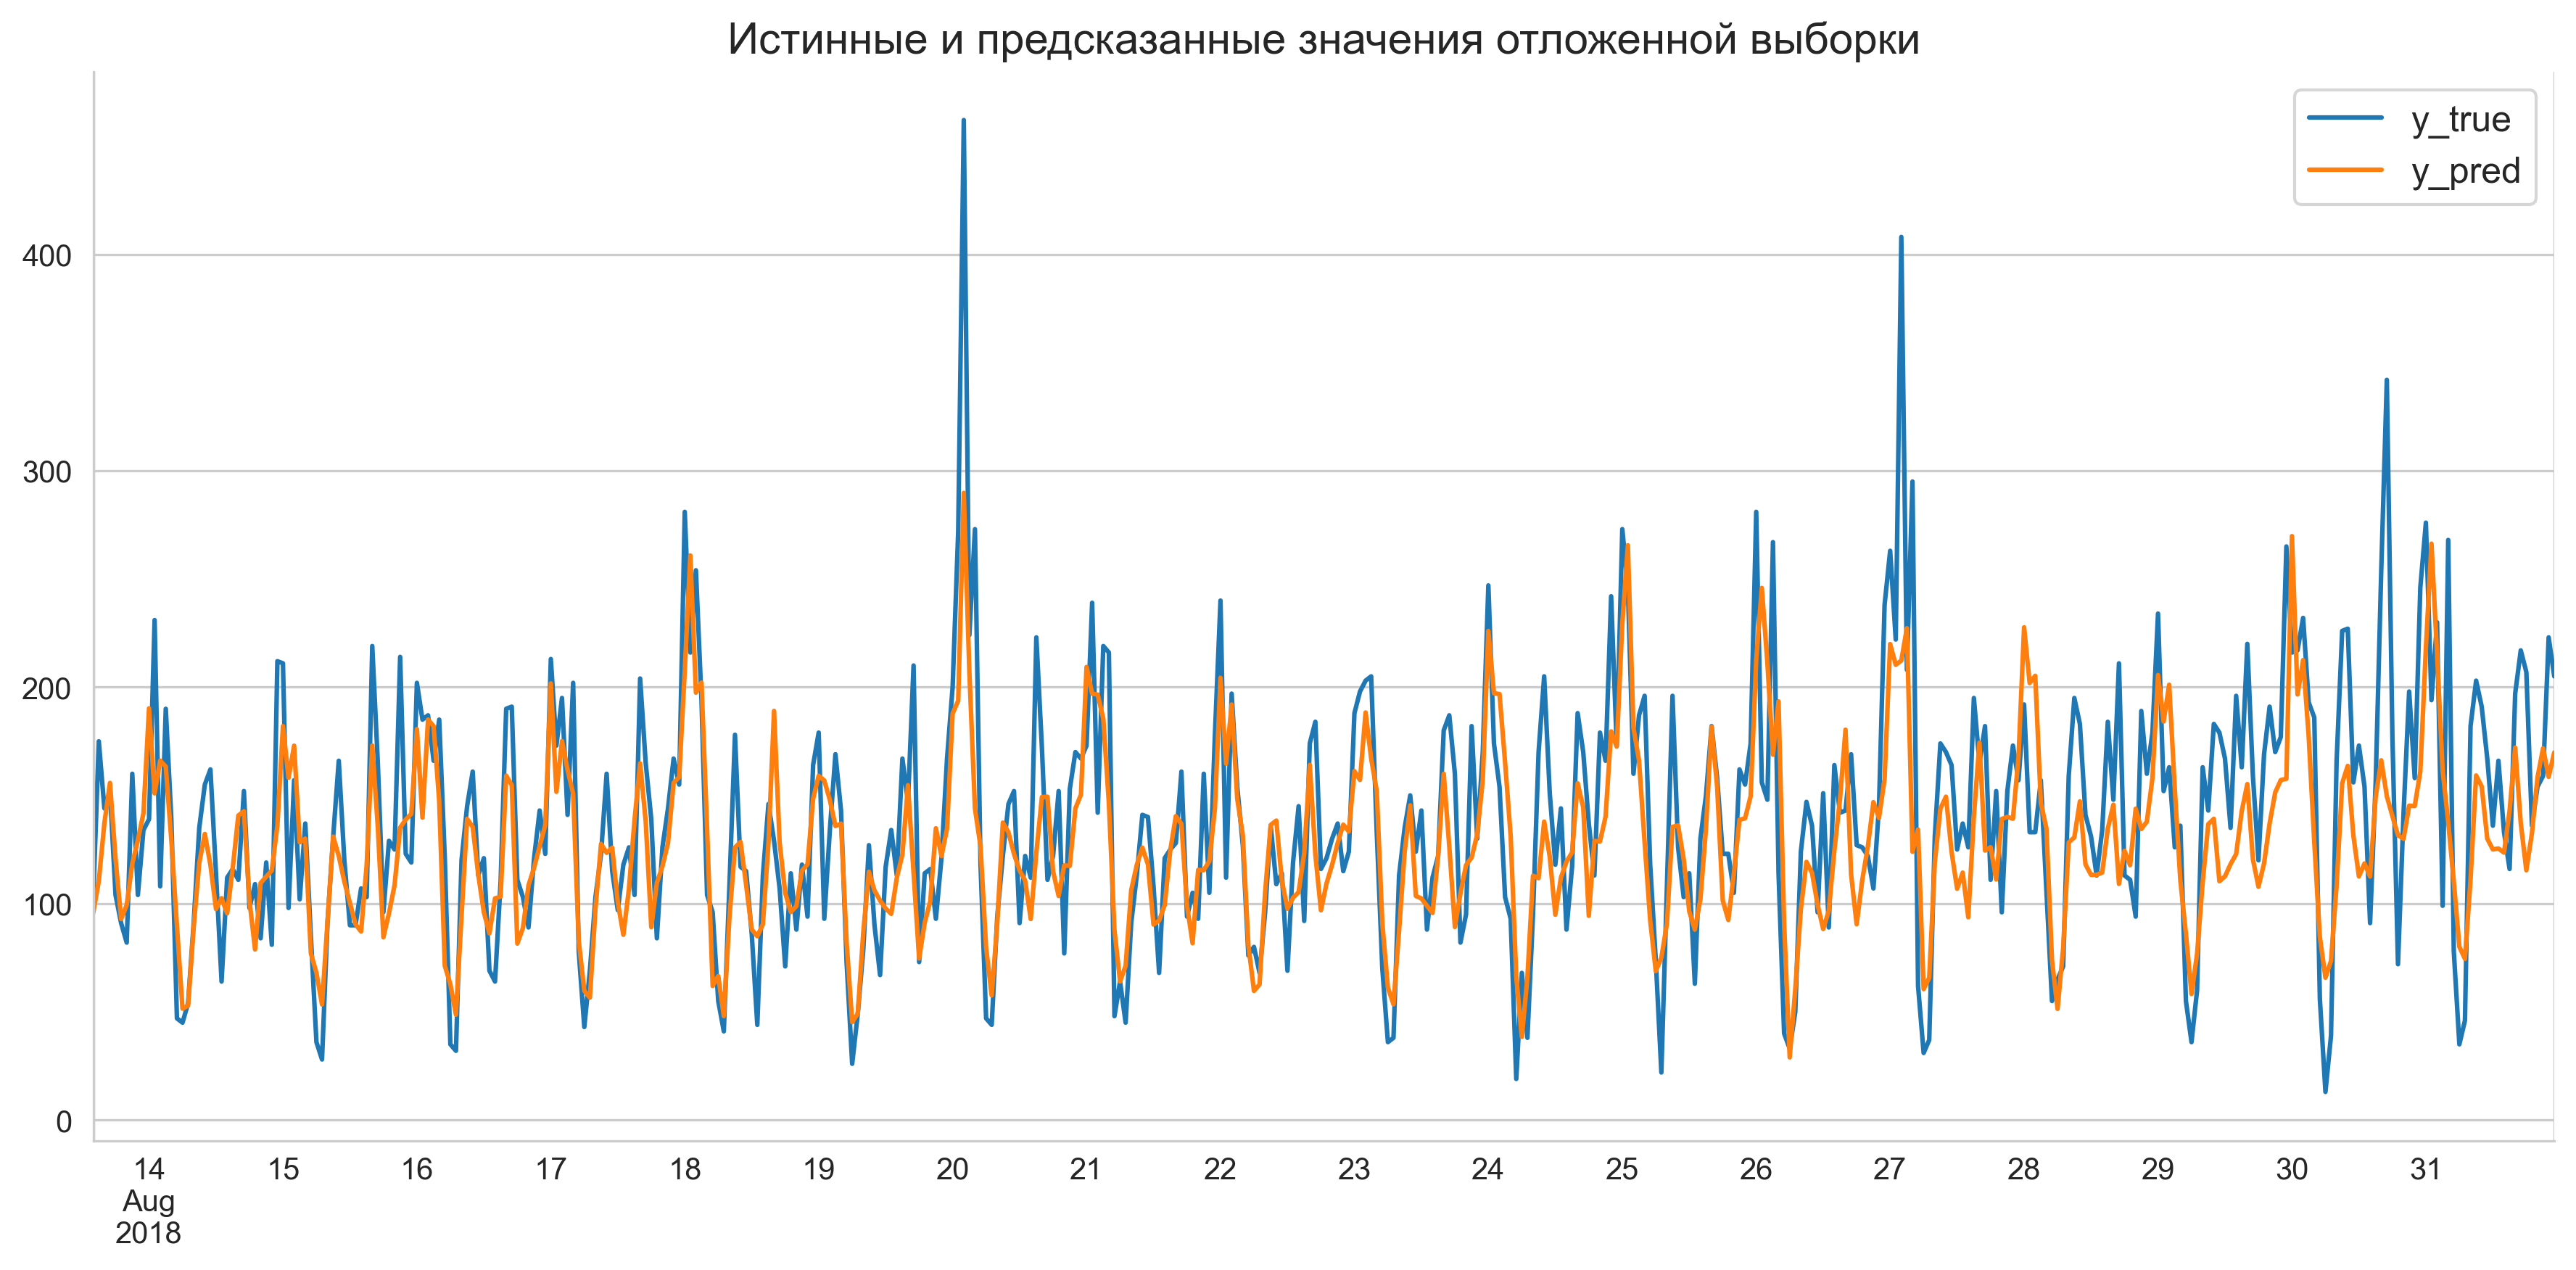

In [27]:
pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot()
plt.title('Истинные и предсказанные значения отложенной выборки')
plt.xlabel('');

Модель неплохо предсказала заказы на новых (отложенных) данных, в среднем ошибаясь на 40 заказов, что меньше бейзлайна RMSE 48, но хуже кросс-валидации. По графику видно, что модель плохо отрабатывает пиковые значения и некоторые волатильные колебания. В целом модель повторяет график истинных значений. 

Теперь мы можем использовать обученную модель для предсказания заказов такси на ближайший час. Для этого необходимо передать модели данные по заказм за последние 25 часов. После выделения признаков из ряда первые 24 часа будут содержать пропуски, а по последнему часу будет происходить предсказание. Напишем функцию для предсказания количества заказов на ближайший час. Для имитации рабочего процесса в качестве актуальных данных мы возьмём последние 25 часов нашего временного ряда. 

In [28]:
# объявляем функцию для предсказния
def predict_order(data):
    '''
    Функция делает предсказания заказов такси
    на ближайший час. Передаваемые данные должны быть
    одноуровневым временным рядом с периодом 1 час,
    и содержать не менее 25 наблюдений. 
    
    Параметры:
    ----------
    data : Series
        Временной ряд в виде серии.
        
    Возвращает:
    -----------
    Функция возвращает предсказнное значение,
    окурглённое до целых.
    '''
    # проверяем условие, что ряд не меньше 25 часов     
    if len(data) > 24:
        # создаём признаки         
        data = make_features(data)
        # удаляем целевой признак
        X = data.drop('num_orders', axis=1)
        # оставляем последний час
        X = X.tail(1)
        # делаем предсказание         
        prediction = best_model.predict(X)
        
        # возвращаем предсказание         
        return int(prediction.round())
    
    # в случае не выполнения условия     
    else:
        # выводим предупреждение
        print('Недостаточно данных для предсказания. Должно быть больше 24 часов.')

In [29]:
# инициируем актуальные данные
actual_data = ts.tail(25)
# делаем предсказания
predict_order(actual_data)

170

Допустим, что сейчас 31 августа 2018 года, 23 часа вечера. На следующий час предполагается 170 заказов такси. Учитывая результаты проведённого анализа, полночь является самым загруженным часом во временном ряде. Данное наблюдение не расходится в логике с предсказнным значением. 

# Вывод <a class='anchor' id='conclusion'></a>

Целью нашего проекта является построенная модель, которая сможет спрогнозировать количество заказов такси на следующий час. Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах, и хочет привлечь больше водителей в период пиковой нагрузки.

Мы получили данные, загрузили, и провели первичный обзор. Таблица содержит следующие столбцы:

* datetime — значение даты и времени;
* num_orders — количество заказов.

Перед нами оказался временной ряд — количество заказов такси в определённый момент времени. Судя по первым строкам таблицы интервал отсчёта составляет 10 минут. Всего мы наблюдаем 26496 временных отсечек, пропусков не нет.

Мы преобразовали дату и время в удобный тип данных (datetime64). Для удобства установили индекс таблицы равным datetime. Все даты оказались уникальными и монотонны (имеют хронологический порядок). Согласно условию задачи интервал отсчёта ряда был изменён на 1 час.

Далее мы провели анализ временного ряда и выяснили следующее:

* Ряд содержит период с 1 марта 2018 года по 31 августа 2018 года. Под наблюдение попали два временных сезона — весна и лето. Годовую сезонность отследить не представляется ворзможным из-за неполных данных;
* В среднем за час заказывают такси 84 раза. Вариативность значений — в среднем 45 заказов;
* Декомпозиция позволила нам увидеть явный возрастающий тренд заказов.
* В сезонности имеются циклические суточные колебания: пик заказов приходится на полночь, минимум достигается к утру, в течение дня значения колеблются возле среднего;
* По всем визуальным наблюдениям мы имеем дело с нестационарным рядом. Для формализации наших суждений мы провели статистические тесты на стационарность ряда. Тесты подтвердили, что ряд не стационарный;

После анализа мы определили необходимый инструментарий для прогнозирования и подготовили данные должным образом:

* Для прогнозирования временного ряда мы выбрали методы машинного обучения. Мы использовали:
   
   * простую линейную регрессию;
   * регрессию ElasticNet;
   * случайный лес;
   * градиентные бустинги LightGBM и CatBoost;

* Для данного метода мы модифицировали данные — создали новые признаки на основе временного ряда:
    
   * календарные признаки — тренды и сезонность привязаны к конкретной дате, поэтому имеет смысл из даты выделить месяц, месячный день, день недели. Также полезно будет пометить выходные дни. Так как временной ряд имеет явные часовые циклы, то очень важно выделить часы;
   * отстающие значения — предыдущие значения ряда подскажут, будет ли функция  𝑥(𝑡) расти или уменьшаться. Для этого выделим лаги как одтдельные признаки. Сдвиг значений сделаем от 1 часа до суток, так как (опять таки) мы наблюдаем часовую цикличность;
   * скользящие агрегации и параметры — скользящие среднее и стандартное отклонение как признаки зададут общий тренд ряда. Количество пиков и эксцесс Фишера как признаки формы распределения. Выберем 3 и 6 часовые окна на основании наблюдаемой часовой динамики ряда;

* Разделили данные на обучающую и тестовую выборки. По условию задачи на тест приходится 10% данных, причём это последние по времени наблюдения.

Для проверки качества моделей мы использовали кросс-валидацию с подбором гиперпараметров. Так как у нас были не обычные данные, а временной ряд, то и разбиение при перекрёстной проверке было соответствующее. 

По результатам эксперимента лучше всех отработали бустинги. На втором месте ансамбль деревьев. Хуже всех — регрессии. Тем не менее все модели показали результат лучше установленного порога ошибки — по условию задачи RMSE должен быть не больше 48.

Из бустингов меньше всего ошибался CatBoost, но на обучение ему понадобилось больше всех времени. Так как нас интересовала точность прогнозов, мы выбрали именно его.

Мы провели тестирование на отложенных данных. Модель неплохо предсказала заказы на новых данных, в среднем ошибаясь на 40 заказа. По графику видно, что модель плохо отрабатывает пиковые значения и некоторые волатильные колебания. В целом модель повторяет график истинных значений.

Для того, чтобы использовать обученную модель для предсказания заказов такси на ближайший час, необходимо передать модели данные по заказм за последние 25 часов. Мы написали специальную функцию, которая трансформирует входящие данные, делает предсказание и возвращает результат. 

Для имитации рабочего процесса в качестве актуальных данных мы взяли последние 25 часов нашего временного ряда — 31 августа 2018 года, 23 часа вечера. Предсказанное значение не противоречит наблюдениям загруженности, выведенных при анализе данных. Задачу проекта можно считать выполненной.